# __PREPROCESSING__

In [1]:
!pip install pyarrow

import pandas as pd
import seaborn as sns
import numpy as np
import random
import re
import os

SAMPLE_SIZE = 100000

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
class Dataset:
    def __init__(self, file:str):
        self.file_name : str = file
        self.types : dict = self.load_types()
        self.df : pd.DataFrame = None
        
    def name(self):
        return re.search(r'\/([\w\d]*)\.csv',self.file_name).group(1)
    
    def __types_file__(self):
        return 'types/' + self.name() +'.npy'
        
    def save_types(self):
        np.save(self.__types_file__(), self.types)
        
    def load_types(self):
        if os.path.isfile(self.__types_file__()):
            self.types = np.load(self.__types_file__(),allow_pickle='TRUE').item()
            return self.types
        return None
    
    def col(self,columns:list, index:bool=True,**pd_params)->pd.DataFrame:
        """Loads some columns of the dataframe out of the whole csv file
        
        :param columns: a list of the desired columns
        :type columns: list
        :param index: if True loads also the 'sid' column as the index
        :type index: bool
        :param **pd_params: any other params for pd.read_csv(...)
        :rtype: pd.DataFrame
        """
        col_list = columns
        if 'cts' in col_list:
            pd_params['parse_dates'] = ['cts']
        if index :
            col_list.append('sid')
        return pd.read_csv(self.file_name,
                           usecols=col_list,
                           dtype=self.types, 
                           index_col='sid' if index else None,
                           delimiter='\t', 
                           **pd_params)

datasets = [
    Dataset(file='instagram-dataset/instagram_profiles.csv'), 
    Dataset(file='instagram-dataset/instagram_locations.csv'), 
    Dataset(file='instagram-dataset/instagram_posts.csv')
]
profiles, locations, posts = datasets

In [3]:
profiles.types = {
#     'sid' : int,
    'profile_id' : int,
    'profile_name' : pd.StringDtype(storage='pyarrow'),
    'firstname_lastname' : pd.StringDtype(storage='pyarrow'),
    'description' : pd.StringDtype(storage='pyarrow'),
    'following' : int,
    'followers' : int,
    'n_posts' : int,
    'url' : pd.StringDtype(storage='pyarrow'),
#     'cts' : pd.DatetimeTZDtype(tz='UTC'), #obtained through parse_dates=['cts']
    'is_business_account' : pd.BooleanDtype()
}
posts.types = {
#     'sid' : int, # gives an error, maybe because it's the index?
    'sid_profile' : int,
    'post_id' : pd.StringDtype(storage='pyarrow'),
    'profile_id' : int,
    'location_id' : int,
    'description' : pd.StringDtype(storage='pyarrow'),
    'post_type' : pd.CategoricalDtype(categories=[1,2,3]),
    'numbr_likes' : int,
    'number_comments' : int
}
locations.types = {
#     'sid' : int, # gives an error, maybe because it's the index?
    'id' : int,
    'name' : pd.StringDtype(storage='pyarrow'),
    'street' : pd.StringDtype(storage='pyarrow'),
    'zip' : pd.StringDtype(storage='pyarrow'),
    'city' : pd.StringDtype(storage='pyarrow'),
    'region' : pd.StringDtype(storage='pyarrow'),
    'cd' : pd.CategoricalDtype(),
    'phone' : pd.StringDtype(storage='pyarrow'),
    'aj_exact_city_match' : pd.BooleanDtype(),
    'aj_exact_country_match' : pd.BooleanDtype(),
    'blurb' : pd.StringDtype(storage='pyarrow'),
    'dir_city_id' : pd.StringDtype(storage='pyarrow'),
    'dir_city_name' : pd.StringDtype(storage='pyarrow'),
    'dir_city_slug' : pd.StringDtype(storage='pyarrow'),
    'dir_country_id' : pd.CategoricalDtype(),
    'dir_country_name' : pd.CategoricalDtype(),
    'lat' : pd.Float32Dtype(),
    'lng' : pd.Float32Dtype(),
    'primary_alias_on_fb' : pd.StringDtype(storage='pyarrow'),
    'slug' : pd.StringDtype(storage='pyarrow'),
    'website' : pd.StringDtype(storage='pyarrow'),
}

In [4]:
def get_types(signed=True, unsigned=True, custom=[]):
    '''Returns a pandas dataframe containing the boundaries of each integer dtype'''
    # based on https://stackoverflow.com/a/57894540/9419492
    pd_types = custom
    if signed:
        pd_types += [pd.Int8Dtype() ,pd.Int16Dtype() ,pd.Int32Dtype(), pd.Int64Dtype()]
    if unsigned:
        pd_types += [pd.UInt8Dtype() ,pd.UInt16Dtype(), pd.UInt32Dtype(), pd.UInt64Dtype()]
    type_df = pd.DataFrame(data=pd_types, columns=['pd_type'])
    type_df['np_type'] = type_df['pd_type'].apply(lambda t: t.numpy_dtype)
    type_df['min_value'] = type_df['np_type'].apply(lambda row: np.iinfo(row).min)
    type_df['max_value'] = type_df['np_type'].apply(lambda row: np.iinfo(row).max)
    type_df['allow_negatives'] = type_df['min_value'] < 0
    type_df['size'] = type_df['np_type'].apply(lambda row: row.itemsize)
    type_df.sort_values(by=['size', 'allow_negatives'], inplace=True)
    return type_df.reset_index(drop=True)
    
get_types()

def downcast_int(file_path, column:str, chunksize=10000, delimiter=',', signed=True, unsigned=True):
    '''Assigns the smallest possible dtype to an integer column of a csv'''
    types = get_types(signed, unsigned)
    negatives = False
    for chunk in pd.read_csv(file_path, usecols=[column],delimiter=delimiter,chunksize=chunksize):
        M = chunk[column].max()
        m = chunk[column].min()
        if not signed and not negatives and m < 0 :
            types = types[types['allow_negatives']] # removes unsigned rows
            negatives = True
        if m < types['min_value'].iloc[0]:
            types = types[types['min_value'] < m]
        if M > types['max_value'].iloc[0]:
            types = types[types['max_value'] > M]
        if len(types) == 1:
            print('early stop')
            break
    return types['pd_type'].iloc[0]

def optimize_cols(file, int_cols, delimiter=',', signed=True, unsigned=True):
    out = dict()
    for col in int_cols:
        out[col] = downcast_int(file, col, delimiter=delimiter, signed=signed, unsigned=unsigned)
    return out

In [5]:
for ds in datasets:
    if not ds.load_types():
        int_cols = [k for k,v in ds.types.items() if v is int]
        print(int_cols)
        ds.types.update(optimize_cols(ds.file_name, int_cols, delimiter='\t'))
        print(f'Optimized {len(int_cols)} types for {ds.name()}')
#     ds.types.update({k:pd.StringDtype(storage='pyarrow') for k,v in ds.types.items() if v==pd.StringDtype(storage='pyarrow')})
    ds.save_types()
#     print(ds.types)

for ds in datasets:
    ds.df = pd.read_csv(ds.file_name, dtype=ds.types, index_col='sid', delimiter='\t', parse_dates=['cts'], nrows=SAMPLE_SIZE)
    avg_mem_unoptimized = pd.read_csv(ds.file_name, index_col='sid', delimiter='\t', nrows=SAMPLE_SIZE).memory_usage(deep=True).sum()/SAMPLE_SIZE
    avg_mem_optimized = ds.df.memory_usage(deep=True).sum()/SAMPLE_SIZE
    print(f'{ds.name().ljust(19)} mean optimized memory usage per entry:  {round(avg_mem_optimized):3} B vs {round(avg_mem_unoptimized):4} B  : {round(avg_mem_optimized/avg_mem_unoptimized*100,2):5}%') 

instagram_profiles  mean optimized memory usage per entry:  197 B vs  539 B  : 36.51%
instagram_locations mean optimized memory usage per entry:  267 B vs 1113 B  : 23.97%
instagram_posts     mean optimized memory usage per entry:  278 B vs  755 B  : 36.76%


# __RISPOSTE DOMANDE__

### __COLONNE DATASETS__

| Locations | Posts | Profiles |
| :-: | :-: | :-: |
| sid | sid | sid
| id | sid_profile | profile_id
| name | post_id | profile_name
| street | profile_id | firstname_lastname
| zip | location_id | description
| city | cts | following
| region | post_type | followers
| cd | description | n_posts
| phone | numbr_likes | url
| aj_exact_city_match | number_comments | cts


***
__1 - [RQ1] After collecting information, the Data Scientists have to know what dataset they are dealing with, so let's start with an Exploratory Data Analysis (EDA). What can you say about our datasets? Please summarise its main characteristics with visual and tabular methods.__
***

As an initial step we can start by displaying the first 5 lines of the 3 datasets to have an idea of what we are dealing with

Locations dataset:

In [6]:
locations.df.head()

,id,name,street,zip,city,region,cd,phone,aj_exact_city_match,aj_exact_country_match,...,dir_city_name,dir_city_slug,dir_country_id,dir_country_name,lat,lng,primary_alias_on_fb,slug,website,cts
sid,,,,,,,,,,,,,,,,,,,,,
719981,110296492939207,"Playa de Daimuz - Valencia, España",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,...,<NA>,<NA>,NaN,NaN,-0.139475,38.974392,daimuzplaya,playa-de-daimuz-valencia-espana,https://es.wikipedia.org/wiki/Daimuz,2019-05-29 01:21:29.987
719983,274391278,Nová Vieska,<NA>,<NA>,Nová Vieska,<NA>,SK,<NA>,True,False,...,Kis-Újfalu,kis-ujfalu,SK,Slovakia,18.466667,47.866669,<NA>,nova-vieska,<NA>,2019-05-29 01:21:38.037
719985,148885595789195,Everest Today,Himalayas,+977,"Kathmandu, Nepal",<NA>,NP,<NA>,False,False,...,Pasupati,pasupati,NP,Nepal,85.330147,27.70196,EverestToday,everest-today,<NA>,2019-05-29 01:21:46.295
719987,263258277,BULAC - Bibliothèque universitaire des langues...,"65, rue des Grands-Moulins",75013,"Paris, France",<NA>,FR,01 81 69 18 00,False,False,...,13ème Arrondissement Paris,13eme-arrondissement-paris,FR,France,2.375995,48.82724,BULAC.Paris,bulac-bibliotheque-universitaire-des-langues-e...,www.bulac.fr,2019-05-29 01:21:54.355
326443,406147529857708,ABC Cable Networks Group,3800 W Alameda Ave,91505,"Burbank, California",<NA>,US,(818) 569-7500,False,False,...,<NA>,<NA>,NaN,NaN,-118.341866,34.153267,<NA>,abc-cable-networks-group,<NA>,2019-04-02 15:22:55.703


***

Posts dataset:

In [7]:
posts.df.head()

,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
sid,,,,,,,,,
28370919,3496776,BXdjjUlgcgq,2237947779,1022366247837915,2017-08-06 20:06:57,2,Wreckloose! Deevalley bike park laps on the @i...,80,0
28370932,-1,BVg0pbolYBC,5579335020,457426771112991,2017-06-19 09:31:16,1,🙌🏼 believe in ya dreams 🙌🏼 just like I believe...,25,1
28370933,-1,BRgkjcXFp3Q,313429634,457426771112991,2017-03-11 20:05:03,1,#meraviglia #incensi #the #candele #profumo #a...,9,0
28370934,-1,BKTKeNhjEA7,1837592700,457426771112991,2016-09-13 16:27:16,1,#teatime #scorpion #friends #love #mountains #...,4,0
28370935,-1,8-NQrvoYLX,1131527143,457426771112991,2015-10-18 10:19:27,1,thE sky gavE mE a #constEllation,8,0


Profiles dataset:

In [8]:
profiles.df.head()

,profile_id,profile_name,firstname_lastname,description,following,followers,n_posts,url,cts,is_business_account
sid,,,,,,,,,,
4184446,4721049632,jphillip033,John Pierce,"""Document Everything Always""",250,146,170,<NA>,2019-08-01 14:38:55.394000-04:00,False
4184457,590583002,mama_haas,Deanna,Trying to enjoy the simple things in life. Kni...,534,1145,2878,www.etsy.com/shop/MamaHaas69,2019-08-01 14:39:36.526000-04:00,False
4184460,1074146658,yellowlightbreen,Eliza Gray,Maine is for Lovers,469,324,431,elizajanegray.com,2019-08-01 14:39:54.407000-04:00,False
4184461,1472038842,tec1025,Thomas Clark,<NA>,<NA>,<NA>,<NA>,<NA>,2019-08-01 14:40:06.472000-04:00,<NA>
4184462,3531420803,luckyfluff,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2019-08-01 14:40:07.806000-04:00,<NA>



Now let's try to have a summary of the most important information of the three datasets starting with their dimensions (in terms of rows $\times$ columns)


In [9]:
print(f"Locations dataset --> {locations.df.shape}")
print(f"Posts dataset --> {posts.df.shape}")
print(f"Profiles dataset --> {profiles.df.shape}")

Locations dataset --> (100000, 22)
Posts dataset --> (100000, 9)
Profiles dataset --> (100000, 10)


We have three pretty big datasets, let's display the name of the variables (columns) for each of them with the information related to the number of "Non null" values and the type we have choose to assign to them.

Locations dataset:

In [10]:
locations.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 719981 to 807738
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      100000 non-null  UInt64        
 1   name                    100000 non-null  string        
 2   street                  67518 non-null   string        
 3   zip                     65807 non-null   string        
 4   city                    90615 non-null   string        
 5   region                  95 non-null      string        
 6   cd                      90705 non-null   string        
 7   phone                   55137 non-null   string        
 8   aj_exact_city_match     97677 non-null   boolean       
 9   aj_exact_country_match  97677 non-null   boolean       
 10  blurb                   36661 non-null   string        
 11  dir_city_id             48279 non-null   string        
 12  dir_city_name           4

Posts dataset:

In [11]:
posts.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 28370919 to 28472844
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   sid_profile      100000 non-null  Int32         
 1   post_id          100000 non-null  string        
 2   profile_id       100000 non-null  UInt64        
 3   location_id      100000 non-null  UInt64        
 4   cts              100000 non-null  datetime64[ns]
 5   post_type        100000 non-null  category      
 6   description      91905 non-null   string        
 7   numbr_likes      100000 non-null  Int64         
 8   number_comments  100000 non-null  UInt32        
dtypes: Int32(1), Int64(1), UInt32(1), UInt64(2), category(1), datetime64[ns](1), string(2)
memory usage: 26.5 MB


Profiles dataset:

In [12]:
profiles.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 4184446 to 4285016
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   profile_id           99998 non-null   UInt64 
 1   profile_name         100000 non-null  string 
 2   firstname_lastname   95733 non-null   string 
 3   description          50170 non-null   string 
 4   following            63022 non-null   UInt32 
 5   followers            63022 non-null   UInt32 
 6   n_posts              63022 non-null   UInt32 
 7   url                  22613 non-null   string 
 8   cts                  99974 non-null   object 
 9   is_business_account  63022 non-null   boolean
dtypes: UInt32(3), UInt64(1), boolean(1), object(1), string(4)
memory usage: 14.2+ MB


We can now start to compute some statistics

Let's start with the "Posts" dataset for which we choose the columns "numbr_likes" and "numbr_comments":

In [13]:
posts.df[["numbr_likes", "number_comments"]].describe()

,numbr_likes,number_comments
count,100000.000000,100000.000000
mean,325.856710,7.582170
std,5512.736285,124.782766
min,0.000000,0.000000
25%,20.000000,0.000000
50%,48.000000,2.000000
75%,126.000000,5.000000
max,852230.000000,31655.000000


And now the "Profiles" dataset for which we choose "following", "followers" and "n_posts"

In [14]:
profiles.df[["following", "followers", "n_posts"]].describe()

,following,followers,n_posts
count,63022.000000,6.302200e+04,63022.000000
mean,805.227460,8.153461e+03,576.003745
std,1079.162713,1.220786e+05,1137.808700
min,0.000000,0.000000e+00,0.000000
25%,225.000000,2.620000e+02,85.000000
50%,494.000000,6.530000e+02,241.000000
75%,932.000000,1.475000e+03,631.000000
max,7597.000000,1.167298e+07,41762.000000


An important information to know when analyzing a dataset is the number of missing values for each variables. We already found the numbers of "Non null" but let's now visualize, trough a barplot for each dataset, which are the proportions of "NaN"

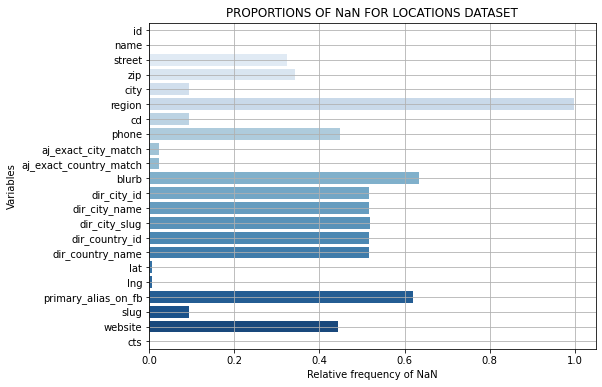

In [15]:
# magari potrei usare il lollipop plot
plt.rcParams['figure.figsize'] = [8,6]
sns.barplot(x=np.array(locations.df.isna().sum())/len(locations.df), y=locations.df.columns.values.tolist(), palette="Blues")
plt.title("PROPORTIONS OF NaN FOR LOCATIONS DATASET")
plt.xlabel("Relative frequency of NaN")
plt.ylabel("Variables")
plt.grid()

The barplot shows that for some variables we don't have around 50% of the observation, for the variable "region" this proportion it's much higher, we miss almost all the values.

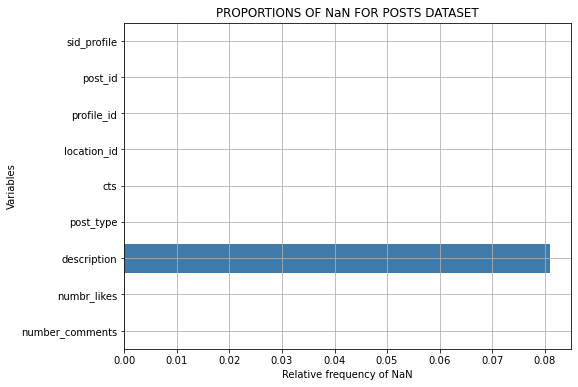

In [16]:
sns.barplot(x=np.array(posts.df.isna().sum())/len(posts.df), y=posts.df.columns.values.tolist(), palette="Blues")
plt.title("PROPORTIONS OF NaN FOR POSTS DATASET")
plt.xlabel("Relative frequency of NaN")
plt.ylabel("Variables")
plt.grid()

For this dataset we have very few _NaN_ and they are all present in the variable "Description"

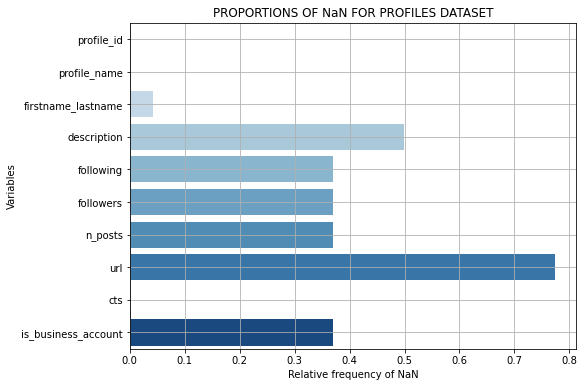

In [17]:
sns.barplot(x=np.array(profiles.df.isna().sum())/len(profiles.df), y=profiles.df.columns.values.tolist(), palette="Blues")
plt.title("PROPORTIONS OF NaN FOR PROFILES DATASET")
plt.xlabel("Relative frequency of NaN")
plt.ylabel("Variables")
plt.grid()

With this last barplot we can see that "following", "followers" and "n_posts" have the same percentage of _NaN_ and that "url" it's by far the variable with the most number of missing values. We miss a lot of values also for the variable "description" and "is_business_account"

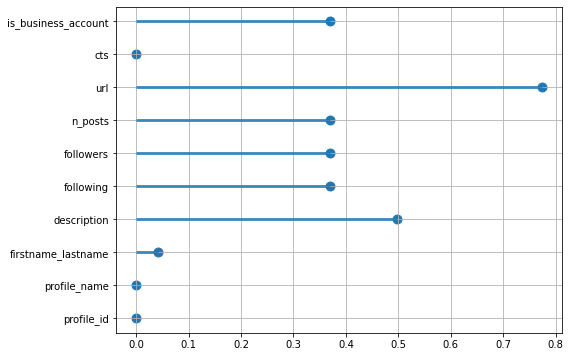

In [50]:
# https://aakashkh.github.io/python/visualisation/2019/08/23/Plotting-Seaborn-Heatmap-Lollipop.html
values = np.array(profiles.df.isna().sum())/len(profiles.df)
my_range =range(0,len(values))
names = profiles.df.columns.values.tolist()
plt.grid()
plt.hlines(y=names, xmin=0, xmax=values, linewidth=3, alpha=0.8)
plt.scatter(valori, my_range, s=80, alpha=1)

Number likes and comments distribution (visualized with an histogram)

Number of followers, following and posts distribution (visualized with an histogram)

In [18]:
# sns.histplot(data=profiles.df, x="followers")

***

__4 - [RQ4] In most cases, we will not have a consistent dataset, and the one we are dealing with is not an exception (ex. in the given datasets, you may not find the information of the profiles for some of the posts). So let’s enhance our analysis.__

$\bullet$ Write a function that, given a profile_id, will be able to return the posts that belong to the given profile_id.

In [19]:
# andrà bene tutta la riga o vanno mostrate solo alcune colonne?
def post_finder(prof_id):
    posts_found = posts.df[posts.df["profile_id"]==prof_id]
    return posts_found[["profile_id", "post_id", "numbr_likes", "number_comments"]]
example = 5337907015
post_finder(example)

,profile_id,post_id,numbr_likes,number_comments
sid,,,,
28452682,5337907015,BxTV32ahahQ,15,2
28452667,5337907015,BsRarTBBPmd,30,6
28452668,5337907015,BqOlb0kBQ5V,25,5
28452669,5337907015,BtxQHmLhI1h,26,11
28452672,5337907015,Bic19O-liDj,28,0
28452673,5337907015,BsTLZELBTnU,28,0
28452674,5337907015,BqTsJM_FDQ_,28,0
28452675,5337907015,ByB_OFnnGFM,19,0
28452676,5337907015,BxxLqEyHlyg,24,0


$\bullet$ Write another function that, given an input n (an integer), will return the posts that belong to the n top posted profiles (top n profiles that have posted the highest number of posts) that their data is available in the profile.csv using the previously written function.

In [20]:
def top_posts_profiles(n):
    prof = posts.df["profile_id"].value_counts().head(int(n)).index.tolist()
    return posts.df.loc[posts.df['profile_id'].isin(prof), ["profile_id", "post_id", "numbr_likes", "number_comments"]]
example = 2
top_posts_profiles(example)

,profile_id,post_id,numbr_likes,number_comments
sid,,,,
28376292,4048041553,Bie10T0ATk8,51,0
28376293,4048041553,BiMg_vhA5EX,49,0
28376301,4048041553,Bx974UqAe8c,42,2
28376294,4048041553,BgiugHxFCN7,49,0
28376295,4048041553,BdR1Z8wDf0D,50,0
...,...,...,...,...
28429007,195747313,Bd3BVedn5k1,4,0
28429008,195747313,BdTXDocnbRK,22,1
28429009,195747313,BdTKguAHRNr,30,0


In [27]:
# prova 2: da rivedere...
posts.df.nlargest(3, 'profile_id', keep='all')

,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
sid,,,,,,,,,
28449640,-1,ByFn0ZgoGlU,14253768105,1015596061,2019-05-30 15:10:06,1,#fashion #shopping #style #nycstyle #shopper #...,11,0
28449641,-1,ByFnPZII_Pd,14253768105,1015596061,2019-05-30 15:05:03,1,#fashion #shopping #style #nycstyle #shopper #...,11,0
28449643,-1,ByFiPyInHU9,14253768105,1015596061,2019-05-30 14:21:24,1,#fashion #shopping #style #nycstyle #shopper #...,12,1
28449645,-1,ByFffJrISLW,14253768105,1015596061,2019-05-30 13:57:17,1,#fashion #shopping #style #nycstyle #shopper #...,11,2


$\bullet$ What is the average number of "likes" and comments of the top 10 profiles with the highest number of posts which their information is available in profile.csv?

In [21]:
top10_profiles = posts.df["profile_id"].value_counts().head(int(10)).index.tolist()
for profile in top10_profiles:
    print(round(posts.df.loc[posts.df['profile_id'] == profile, ['numbr_likes', "number_comments"]].mean(),3))

numbr_likes        18.317
number_comments     1.000
dtype: float64
numbr_likes        149.061
number_comments      3.879
dtype: float64
numbr_likes        11.636
number_comments     0.667
dtype: float64
numbr_likes        34.697
number_comments     2.818
dtype: float64
numbr_likes        20.031
number_comments     1.500
dtype: float64
numbr_likes        27.188
number_comments     0.938
dtype: float64
numbr_likes        42.719
number_comments     0.500
dtype: float64
numbr_likes        177.031
number_comments      2.844
dtype: float64
numbr_likes        42.781
number_comments     1.875
dtype: float64
numbr_likes        30.531
number_comments     0.438
dtype: float64


$\bullet$ Plot the number of posts that these top 10 profiles have sent on Instagram in the given interval in question RQ3. Interpret the resulting chart.

In [22]:
def inter(h,inters):
    assert inters[0] == 0 and inters[-1]==24, 'Intervals list must start at 0 and end at 24'
    for i in range(len(inters) - 1):
        if h >= inters[i] and h < inters[i+1]:
            return i

In [23]:
# semplicemente un istogramma
subset_4_4 = posts.col(['profile_id', 'cts'], index=False, nrows=SAMPLE_SIZE)
subset_4_4 = subset_4_4[subset_4_4["profile_id"].isin(top10_profiles)]
subset_4_4['hour'] = subset_4_4['cts'].map(lambda x: x.hour).astype('Int8')
subset_4_4['intervals'] = subset_4_4['hour'].map(lambda h :inter(h, [0,3,6,11,14,17,20,24]))

In [24]:
prof_posts_hour = pd.crosstab(subset_4_4.profile_id, subset_4_4.intervals).replace(0,np.nan).\
     stack().reset_index().rename(columns={0:'Time'})

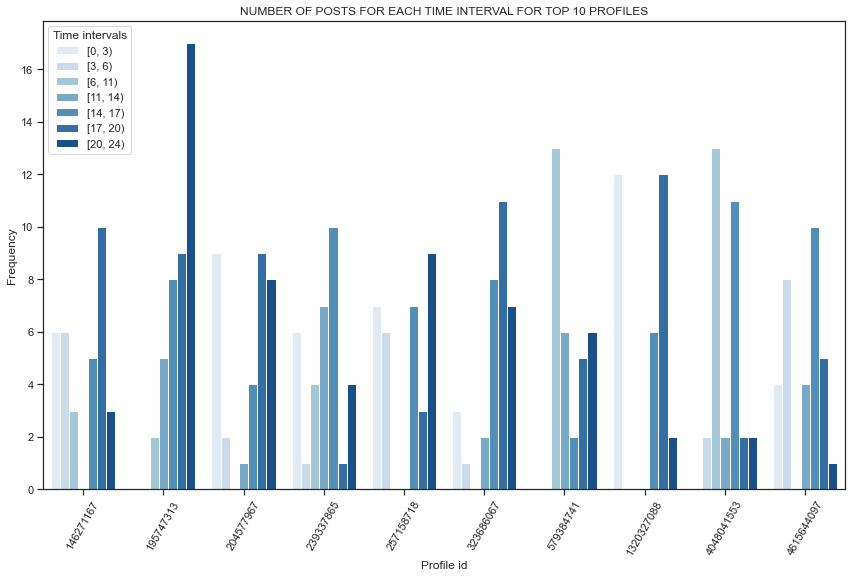

In [38]:
labels=["[0, 3)","[3, 6)", "[6, 11)", "[11, 14)", "[14, 17)", "[17, 20)", "[20, 24)"]
ax = sns.barplot(data=prof_posts_hour, x="profile_id", y="Time", hue="intervals", palette="Blues")
plt.xticks(rotation=60)
plt.tight_layout()
plt.title("TOP 10 PROFILES: NUMBER OF POSTS FOR EACH TIME INTERVAL")
plt.xlabel("Profile id")
plt.ylabel("Frequency")
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, title="Time intervals", loc='upper left')
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme(style="whitegrid")
plt.show()

__7 - [RQ7] Of course, calculating probabilities is a job that any Data Scientist must know. So let's compute some engaging figures.__

$\bullet$ What's the probability that a post receives more than 20% "likes" of the number of followers a user has?

In [55]:
# First we create a subset of the posts dataframe that contains only the columns that we need
# and the rows for which we have a match (with the user) in the profiles dataset
sub_posts = posts.df[["sid_profile", "numbr_likes"]][posts.df['sid_profile'] != -1]
# We create also a subset for the profiles dataset which contain only "sid" and "followers" and the rows different from NaN
sub_prof = profiles.df[["followers"]].dropna()
# At this point we merge the to subsets on "sid_profile"
merged_df = pd.merge(sub_posts, sub_prof, left_on="sid_profile", right_on=sub_prof.index)
# Then we can calculate the numbers of positive cases
pos_cases = (merged_df.apply(lambda x: x.numbr_likes > x.followers*0.2, axis=1)).sum()
# And finally we calculate the probability dividing the positive cases for the total number of evaluated posts
print(f"Probability is equal to: {round(pos_cases/merged_df.shape[0], 5)*100}%")

          sid_profile  numbr_likes
sid                               
28370919      3496776           80
28370963      3303402          114
10318140      3406435           46
28370948      3529017           66
28370984      3206132         1983
(43598, 2)
         followers
sid               
4184446        146
4184457       1145
4184460        324
4184465        192
4184471       4137
(353624, 1)
   sid_profile  numbr_likes  followers
0      4376375            9       1263
1      4368355          652      27753
2      4368355          303      27753
3      4471259          128      26373
4      4471259          106      26373
(1869, 3)
115
Probability is equal to: 6.1530000000000005%


$\bullet$ Do users usually return to locations? Extract the probability that a user returns to a site after having posted it in the past. Does that probability make sense to you? Explain why or why not.

In [34]:
# Da provare con value_counts(?) perche cosi potrebbe dare problemi con il chunking
# forse non è possibile usare il chunking, caricare solo le colonne necessarie e effettuare analisi su tutte le righe

#sub_loc = locations.df[["id", "name"]]
#sub_loc['id'].duplicated().sum()

# First we create a subset that contains only the necessary columns
sub_7_2 = posts.df[["profile_id", "location_id"]]
# Then we eliminate the rows that do not contain duplicates in the values of the two columns
sub_7_2_mod = sub_7_2[sub_7_2.duplicated(subset=["profile_id", "location_id"], keep=False)]
# As a last step we eliminate the duplicates and take the value of the number of rows left
n_duplicates = sub_7_2_mod.drop_duplicates(subset=["profile_id", "location_id"]).shape[0]
# We are now ready to calculate the probability that has to take as denominator the number of total different users...
prob_dupl1 = n_duplicates / sub_7_2.nunique()[0]
# più giusta questa perchè tiene contoo delle differenti coppie al denominatore
prob_dupl2 = n_duplicates / sub_7_2.groupby(["profile_id", "location_id"]).ngroups
print(f"Probability that a user returns to a site after having posted it in the past is equal to: {round(prob_dupl1,4)*100}%")
print(f"Probability that a user returns to a site after having posted it in the past is equal to: {round(prob_dupl2,4)*100}%")

Probability that a user returns to a site after having posted it in the past is equal to: 10.42%
Probability that a user returns to a site after having posted it in the past is equal to: 10.38%


In [22]:
# check if a profile is in the dataset
# profiles.df[profiles.df["profile_name"]=="b_iancaneve"]

,profile_id,profile_name,firstname_lastname,description,following,followers,n_posts,url,cts,is_business_account
sid,,,,,,,,,,


### 8. __[RQ8] Every decision you take in a data-based environment should be reinforced with charts, statistical tests and analysis methods to check whether a hypothesis is correct or not.__

#### $\bullet$ Does more “likes” also mean more comments? Plot a scatter plot of “likes” vs comments for posts.

In [28]:
posts8 = posts.col(['post_id', 'numbr_likes', 'number_comments'], index=False, nrows=SAMPLE_SIZE)

[None, None]

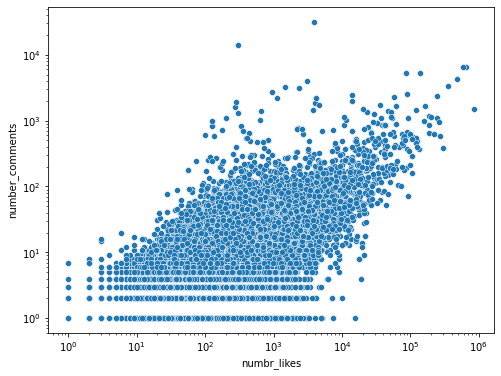

In [31]:
scatter_plot = sns.scatterplot(data=posts8, x="numbr_likes", y="number_comments")
scatter_plot.set(xscale="log", yscale="log")

#### $\bullet$ Can you find any significant relationship between the time a user publishes a post and the number of comments and “likes”? Use an appropriate statistical test or technique and support your choice.

#### $\bullet$ What’s the distribution of followers? Plot the empirical distribution of followers amongst all users and extract the mean, mode, and quantiles. Interpret those figures.

#### $\bullet$ What are histograms, bar plots, scatterplots and pie charts used for?

_per ora è solo un copia e incolla da internet, scrivere meglio casi in cui vengono utilizzati_

$\bullet$ Histograms are used to summarize discrete or continuous data that are measured on an interval scale. It is often used to illustrate the major features of the distribution of the data in a convenient form. It is also useful when dealing with large data sets because it can help in detecting any unusual observations (outliers) or any gaps in the data. 
A histogram divides up the range of possible values in a data set into classes or groups. For each group, a rectangle is constructed with a base length equal to the range of values in that specific group and a length equal to the number of observations falling into that group. A histogram has an appearance similar to a vertical bar chart, but there are no gaps between the bars. Generally, a histogram will have bars of equal width. 

$\bullet$ A bar plot is a chart that presents categorical data with rectangular bars with heights or lengths proportional to the values that they represent. The bars can be plotted vertically or horizontally.
A bar plot shows comparisons among discrete categories. One axis of the chart shows the specific categories being compared, and the other axis represents a measured value. They can also represent bars clustered in groups of more than one, showing the values of more than one measured variable.

$\bullet$ A scatterplot is a type of plot or mathematical diagram that use cartesian coordinates to display values for typically two variables for a set of data. If the points are coded (color/shape/size), one additional variable can be displayed. The data are displayed as a collection of points, each having the value of one variable determining the position on the horizontal axis and the value of the other variable determining the position on the vertical axis.

$\bullet$ A pie chart is a circular statistical graphic, which is divided into slices to illustrate numerical proportion. In a pie chart, the arc length of each slice (and consequently its central angle and area) is proportional to the quantity it represents.

#### $\bullet$ What insights can you extract from a Box Plot?

Box plots provide a quick visual summary of the variability of values in a dataset. They show the median, upper and lower quartiles, minimum and maximum values, and any outliers in the dataset. Outliers can reveal mistakes or unusual occurrences in data. A box plot is created using a number or rate/ratio field on the y-axis.

Box plots are usefull to answer questions like: How is my data distributed? Are there any outliers in the dataset? 

| Component | Description |
|---|---|
| Whisker | The range of data less than the first quartile and greater than the third quartile. Each whisker has 25 percent of the data. Whiskers typically cannot be more than 1.5 times IQR, which sets the threshold for outliers. |
| Box | The range of data between the first and third quartiles. 50 percent of the data lies within this range. The range between the first and third quartile is also known as the Inter Quartile Range (IQR). |
| Maximum | The largest value in the dataset or the largest value that is not outside the threshold set by the whiskers. |
| Third quartile | The value where 75 percent of the data is less than the value, and 25 percent of the data is greater than the value. |
| Median | The middle number in the dataset. Half of the numbers are greater than the median and half are less than the median. The median can also be called the second quartile. |
| First quartile | The value where 25 percent of the data is less than the value, and 75 percent of the data is greater than the value. |
| Minimum| The smallest value in the dataset or the smallest value that is not outside the threshold set by the whiskers. |
| Outliers| Data values that are higher or lower than the limits set by the whiskers. |

In [6]:
# RQ2_1.dropna(inplace=True)

In [6]:
# RQ2_1.head()

,profile_id,n_posts
0,4.721050e+09,170.0
1,5.905830e+08,2878.0
2,1.074147e+09,431.0
5,1.450642e+08,590.0
6,2.061868e+09,753.0


In [12]:
# RQ2_1_2 = RQ2_1.sort_values(by=['n_posts'], ascending=False)[:100]

In [8]:
# RQ2_1_2.shape

(100, 2)

In [22]:
# RQ2_1_2["n_posts"].min()

18811.0

In [41]:
#asdf = pd.DataFrame(profiles.df["n_posts"].value_counts())
#asdf.plot(x="n_posts", y=asdf.index, kind="bar", xticks=[], legend=False)

In [ ]:
asdf.plot(x="profile_id", y="n_posts", kind="bar", xticks=[], legend=False)

<AxesSubplot:xlabel='profile_id'>

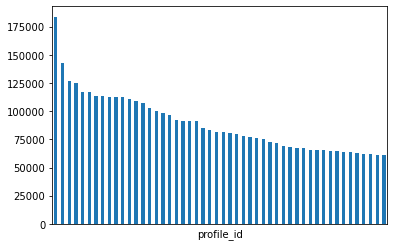

In [13]:
# RQ2_1_2.plot(x="profile_id", y="n_posts", kind="bar", xticks=[], legend=False)

--- EXPLORATORY DATA ANALYSIS (EDA) ---

In [46]:
### Locations dataset ###
#print(df_loc.shape)
#print(df_loc.isna().sum())

### Posts dataset ###
#print(df_posts.shape)
#print(df_posts.isna().sum())

### Profiles dataset ###
# print(df_prof.shape)
#print(df_prof.isna().sum())
# print(df_prof["followers"].max())
# print(df_prof["followers"].mean())

(4509586, 11)
285457645.0
4739.899180397426


In [ ]:
# RQ2_2
# RQ2_2 = df_posts[["post_id", "numbr_likes"]].copy()

### 3. __[AQ2] Considering the following problem, answer the questions:__

#### Alex has a ribbon of length N. He wants to cut the ribbon in a way that fulfils the following __three__ conditions:

#### $\bullet$ Each piece of the cut should have an integer length
#### $\bullet$ He should at least cut the ribbon once
#### $\bullet$ The __multiplication__ of the length of all the pieces be the maximum possible

#### 1. Implement a __recursive algorithm__ to help Alex find the maximum possible value after multiplying the length of the pieces. Explain your algorithm in detail.

In [ ]:
# link problema simile https://en.wikipedia.org/wiki/Subset_sum_problem

In [6]:
# Devo lavorare solo con interi 
# Il minimo input possibile è 2 perchè devo poter fare almeno un taglio
# Voglio massimizzare il prodotto della lunghezza dei tagli
# L'algoritmo deve essere ricorsivo


27

#### 2. Show that the algorithm has exponential running time.

#### 3. Now provide a polynomial solution, based on __dynamic programming__, and compute its running-time complexity.

3140085798164163223281069126

#### 4. Evaluate the running time of your algorithm for the sizes (Ns) in the __range of [2, 25]__, plot the results, and interpret it (if you have implemented two algorithms, please include both in the plot and compare them).

#### 5. (Optional, mini bonus) Is the algorithm of question 3 __optimal__? If you belive it, can you prove it? If not, can you find a faster algorithm? In case you found a faster algorithm implement it and explain your algorithm in detail.

In [ ]:
def ribbon_cut_top(n):
    # n = int(n) 
    if n < 2:
        print("Input not valid. Try with an int greater than 2")
    elif n == 2:
        return 1
    elif n == 3:
        return 2
    elif n == 4:
        return 4
    else:
        if n % 3 == 0:
            return int(3 ** (n / 3))
        elif (n + 1) % 3 == 0:
            return int(3 ** (n // 3) * 2)
        else: # (n+1) % 3 == 0
            return int(3 ** (n // 3 - 1) * (4))
ribbon_cut(17)